In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
import datetime
import urllib.request as req
from bs4 import BeautifulSoup

from pandas_datareader import data as pdr
import yfinance as yf

yf.pdr_override()

In [2]:
# JPXのETF一覧ページ
url = 'https://www.jpx.co.jp/equities/products/etfs/issues/01.html'

In [3]:
# 各商品の証券コードを取得
response = req.urlopen(url)
soup = BeautifulSoup(response, "html.parser")

attribute = []
div = soup.find('div', class_='component-normal-table')
table = div.find('table')
rows = table.find_all('tr')

tickers = []
for i, row in enumerate(rows):
    row_text = [td.get_text(strip=True) for td in row.select('th, td')]
    if i==0:
        continue
    tickers.append(row_text[1]+'.T')
print(len(tickers))


260


In [4]:
# 一年のうち取引が行われる日数
YEARLY_TRAIDING_DAYS = 252
# データ取得期間
START = pd.to_datetime('2012-01-01') 
END = pd.to_datetime('2022-12-31')

str_duration = START.strftime('%Y-%m-%d') + '_' + END.strftime('%Y-%m-%d')

f_tickers = 'data/tickers/' + str_duration + '_' +  'tickers.pickle'
f_returns = 'data/returns/' + str_duration + '_' +  'adj_close.csv'

In [5]:
tic = yf.Ticker('1305.T')
tic.info

{'phone': '+81-3-5555-3111',
 'maxAge': 86400,
 'priceHint': 2,
 'previousClose': 2455.0,
 'open': 2463.0,
 'dayLow': 2450.0,
 'dayHigh': 2474.5,
 'regularMarketPreviousClose': 2455.0,
 'regularMarketOpen': 2463.0,
 'regularMarketDayLow': 2450.0,
 'regularMarketDayHigh': 2474.5,
 'trailingPE': 14.424674,
 'volume': 196260,
 'regularMarketVolume': 196260,
 'averageVolume': 302030,
 'averageVolume10days': 551296,
 'averageDailyVolume10Day': 551296,
 'bid': 2456.5,
 'ask': 2457.5,
 'bidSize': 0,
 'askSize': 0,
 'yield': 0.0207,
 'totalAssets': 8231914045440,
 'fiftyTwoWeekLow': 1912.5,
 'fiftyTwoWeekHigh': 2474.5,
 'fiftyDayAverage': 2309.32,
 'twoHundredDayAverage': 2121.6226,
 'navPrice': 2456.7,
 'currency': 'JPY',
 'ytdReturn': 0.22811411,
 'beta3Year': 0.95,
 'fundFamily': 'Daiwa Asset Management Co Ltd',
 'fundInceptionDate': 994809600,
 'legalType': 'Exchange Traded Fund',
 'threeYearAverageReturn': 0.1595622,
 'fiveYearAverageReturn': 0.0833357,
 'exchange': 'JPX',
 'quoteType': '

In [6]:
def get_valid_tickers_info(tickers):
    if os.path.isfile(f_tickers):
        with open(f_tickers, 'rb') as f:
            valid_tickers_info = pickle.load(f)
    else:
        valid_tickers_info = {}
        # 各証券についてデータを取得
        for ticker in tickers:
            # 取得期間に証券データが存在しない場合はパスする
            try:
                tic = yf.Ticker(ticker)
                info = tic.info
                firstTradeDate_jst = datetime.datetime.fromtimestamp(tic.history_metadata['firstTradeDate'])
            except:
                continue
            # 取得開始の時期に証券が公開されていない場合はパスする
            if firstTradeDate_jst > START:
                continue
            else:
                print('valid : ', ticker)
                valid_tickers_info[ticker] = info
        
        with open (f_tickers, 'wb') as f:
            pickle.dump(valid_tickers_info, f)
            
    return valid_tickers_info


valid_tickers_info = get_valid_tickers_info(tickers)

In [7]:
valid_tickers_info

{'1305.T': {'phone': '+81-3-5555-3111',
  'maxAge': 86400,
  'priceHint': 2,
  'previousClose': 2455.0,
  'open': 2463.0,
  'dayLow': 2450.0,
  'dayHigh': 2474.5,
  'regularMarketPreviousClose': 2455.0,
  'regularMarketOpen': 2463.0,
  'regularMarketDayLow': 2450.0,
  'regularMarketDayHigh': 2474.5,
  'trailingPE': 14.41587,
  'volume': 196010,
  'regularMarketVolume': 196010,
  'averageVolume': 302030,
  'averageVolume10days': 551296,
  'averageDailyVolume10Day': 551296,
  'bid': 2454.0,
  'ask': 2456.0,
  'bidSize': 0,
  'askSize': 0,
  'yield': 0.0207,
  'totalAssets': 8231914045440,
  'fiftyTwoWeekLow': 1912.5,
  'fiftyTwoWeekHigh': 2474.5,
  'fiftyDayAverage': 2309.32,
  'twoHundredDayAverage': 2121.6226,
  'navPrice': 2408.9,
  'currency': 'JPY',
  'ytdReturn': 0.2043522,
  'beta3Year': 0.95,
  'fundFamily': 'Daiwa Asset Management Co Ltd',
  'fundInceptionDate': 994809600,
  'legalType': 'Exchange Traded Fund',
  'threeYearAverageReturn': 0.15203491,
  'fiveYearAverageReturn': 0

In [8]:
valid_tickers = list(valid_tickers_info.keys())

In [9]:
# 終値のみを取得
def get_adjclose(tickers):
    if os.path.isfile(f_returns):
        data = pd.read_csv(f_returns, index_col=0)
    else:
        data =  pdr.get_data_yahoo(tickers, start=START, end=END)['Adj Close']
        data.to_csv(f_returns)
    return data

# 各商品の１日あたりの対数収益率を計算、対数を取るのは収益率を正規分布に落とし込むため
def calc_D_returns(data):
    returns = np.log(data/data.shift(1))
    return returns

    # N = data.shape[0]
    # list_rate_of_return_per_term = list()
    # for j in range(N - D + 1):
    #     start = j
    #     end = j + D - 1
    #     rate_of_return = np.divide(
    #         data[end] - data[start], data[start]
    #     )
    #     list_rate_of_return_per_term.append(rate_of_return)
    # print()
    # return list_rate_of_return_per_term



data_adjclose = get_adjclose(valid_tickers)
returns = calc_D_returns(data_adjclose)

data_adjclose.to_csv(f_returns)

In [14]:
i = 30

returns = returns.iloc[:, :i]
valid_tickers = valid_tickers[:i]
returns

,1305.T,1306.T,1308.T,1309.T,1311.T,1319.T,1320.T,1321.T,1322.T,1324.T,...,1385.T,1386.T,1387.T,1388.T,1389.T,1390.T,1393.T,1394.T,1540.T,1541.T
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-05,-0.006636,-0.006662,-0.008097,0.000000,-0.005208,0.007491,-0.004646,-0.003470,-0.005358,0.008969,...,-0.014468,-0.008728,-0.013396,-0.010844,-0.007840,-0.014531,0.003256,-0.005610,0.017566,0.001428
2012-01-06,-0.009365,-0.010753,-0.012270,-0.001311,-0.010499,-0.007491,-0.009357,-0.014003,0.000000,-0.018019,...,-0.007745,0.000692,-0.004190,0.000237,0.004384,-0.009454,-0.002115,-0.004311,0.002484,-0.002857
2012-01-10,0.002685,0.004046,0.004107,0.042368,0.005263,-0.022815,0.002347,0.003519,0.028113,0.018019,...,0.021791,0.013054,0.019181,0.004964,0.008349,0.017783,0.011337,0.013371,-0.009975,0.001430
2012-01-11,0.000000,0.000000,0.001365,0.000000,0.000000,-0.007722,0.000000,0.001170,0.002408,0.000000,...,-0.003387,-0.004104,-0.002128,0.004235,-0.004529,0.004139,0.000563,-0.002709,0.011215,0.030945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,0.002995,0.001768,0.003573,-0.002107,-0.002705,0.005134,0.003869,0.005883,-0.000685,0.000000,...,0.003623,0.000000,0.006139,-0.069293,-0.001811,0.003534,0.000000,0.000000,0.001920,0.007605
2022-12-27,0.003483,0.005536,0.003307,0.015180,0.005402,0.008996,0.002571,0.002197,0.022619,0.000000,...,-0.005440,0.000500,0.011903,0.000000,0.002263,0.008780,0.012048,0.009729,0.004647,0.023707
2022-12-28,-0.001242,-0.002010,-0.000762,0.008020,-0.005294,-0.008996,-0.004780,-0.005319,0.004943,0.000000,...,0.003630,0.009450,0.000000,0.000000,0.006758,0.006969,-0.006207,0.000000,0.009634,-0.004944


In [15]:
# 年次リターン
annual_returns = returns.mean()*YEARLY_TRAIDING_DAYS
# 各銘柄の共分散
cov_returns = returns.cov()*YEARLY_TRAIDING_DAYS

In [16]:
def initialize_weights(stocks, fixed_seed=False):
    if fixed_seed:
        np.random.seed(0)
    weights = np.random.random(len(stocks))
    weights /= np.sum(weights)
    return weights

def calc_portfolio_return(returns, weights):
    portfolio_return = np.sum(returns.mean()*weights) * YEARLY_TRAIDING_DAYS
    return portfolio_return

def calc_portfolio_std(returns, weights):
    portfolio_variance = np.dot(weights.T, np.dot((returns.cov()*YEARLY_TRAIDING_DAYS), weights))
    portfolio_standart_deviation = np.sqrt(portfolio_variance)
    return portfolio_standart_deviation

def generate_portfolios(returns, stocks):
    p_returns = []
    p_stds = []
    for _ in range(10000):
        weights = initialize_weights(stocks)
        p_returns.append(calc_portfolio_return(returns, weights))
        p_stds.append(calc_portfolio_std(returns, weights))
    return np.array(p_returns), np.array(p_stds)

def statistics(weights, returns):  
    p_return = calc_portfolio_return(returns, weights)
    p_std = calc_portfolio_std(returns, weights)
    return np.array([p_return, p_std, p_return/p_std])

def min_func(weights, returns):
    # p_return/p_std を最大化する
    # つまり -1 * p_return/p_std を最小化する
    return -statistics(weights, returns)[2]

def optimize_portfolio(weights, returns):
    # 0 <= weight_i <= 1
    bounds = tuple((0, 1) for x in range(len(valid_tickers)))
    # sum of weights = 1
    constraints = ({'type':'eq', 'fun': lambda x: np.sum(x)-1})
    optimized = scipy.optimize.minimize(
        fun=min_func,
        x0=weights, 
        args=returns,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
    )
    return optimized



In [17]:
p_returns, p_stds = generate_portfolios(returns, valid_tickers)
# plt.scatter(p_stds, p_returns, c=p_returns/p_stds)
# plt.grid(True)
# plt.xlabel('Expected Risk')
# plt.ylabel('Expedted Return')
# plt.colorbar(label='Risk-Return-Ratio')
# plt.show()



optimized weights [0.000e+00 0.000e+00 0.000e+00 4.200e-02 0.000e+00 7.840e-02 1.009e-01
 0.000e+00 2.820e-02 0.000e+00 0.000e+00 0.000e+00 5.910e-02 1.308e-01
 0.000e+00 0.000e+00 2.039e-01 0.000e+00 0.000e+00 0.000e+00 1.020e-02
 0.000e+00 0.000e+00 0.000e+00 5.000e-04 3.000e-04 3.000e-04 0.000e+00
 3.453e-01 0.000e+00]
Expected retrun, risk, SharpeRatio [0.08259794 0.11909615 0.69353994]


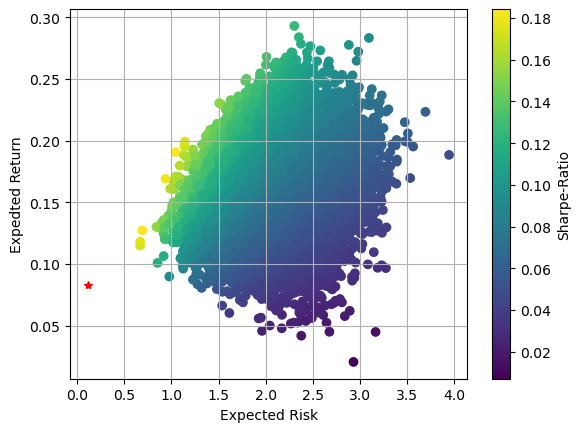

In [18]:
weights = initialize_weights(valid_tickers, fixed_seed=True)
optimized = optimize_portfolio(weights, returns)
optimized_vars = statistics(optimized['x'], returns)
# optimized weights [0.2959 0.     0.     0.3825 0.3216 0.    ]
print('optimized weights', optimized['x'].round(4))
# Expected retrun, risk, SharpeRatio [0.16203813 0.15065529 1.0755555 ]
print('Expected retrun, risk, SharpeRatio', optimized_vars)
plt.scatter(p_stds, p_returns, c=p_returns/p_stds)
plt.grid(True)
plt.xlabel('Expected Risk')
plt.ylabel('Expedted Return')
plt.colorbar(label='Sharpe-Ratio')
plt.plot(optimized_vars[1], optimized_vars[0], '*r')
plt.show()

In [ ]:
p_stds

array([0.13654451, 0.12699018, 0.12424883, ..., 0.12425101, 0.1341987 ,
       0.12639779])